# Stellar surface area occulted by transits of HAT-P-11 b

Below I show the actual transit chord of HAT-P-11 b across its host star using my best-fit transit parameters. 

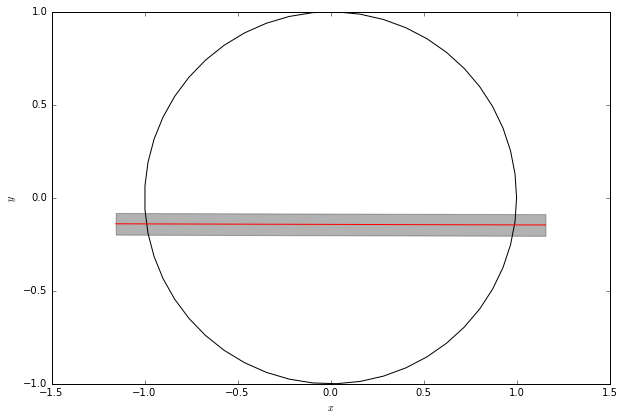

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')
from friedrich.lightcurve import hat11_params_morris
from friedrich.orientation import planet_position_cartesian

transit_params = hat11_params_morris()
start = 0.5
n_times = 1000
interp_duration = 0.005 # fraction of full transit duration
times1 = np.linspace(transit_params.t0 - transit_params.duration/2 - interp_duration, 
                     transit_params.t0 - transit_params.duration/2 + interp_duration, n_times)
times2 = np.linspace(transit_params.t0 + transit_params.duration/2 - interp_duration, 
                     transit_params.t0 + transit_params.duration/2 + interp_duration, n_times)

times = np.concatenate([times1, times2])

x_center, y_center, z_center = planet_position_cartesian(times, transit_params)

y_plus = y_center + transit_params.rp
y_minus = y_center - transit_params.rp

theta = np.linspace(0, 2*np.pi, 50)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.cos(theta), np.sin(theta), color='k')
ax.plot(x_center, y_center, color='r')
#ax.scatter(x, y)
ax.fill_between(x_center, y_minus, y_plus, color='k', alpha=0.3)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

To first order the planet occults a solid band of latitudes in sky-projected coordinates, if we neglect the orbital eccentricity and inclination. Here we're not concerned with the latitudes and longitudes on the stellar surface with respect to the stellar rotation axis, so I refer to latitudes as bands on the stellar surface parallel with the sky-projected x axis. 

The limb of the star is defined by the unit circle in sky coordinates
$$ x^2 + y^2 = 1 .$$
The cross-sectional radius of the star $\rho$ at a given $y$ is 
$$ \rho(y) = \sqrt{1 - y^2}.$$
$$ \rho^\prime(y) = y(1 - y^2)^{-1/2}$$
The circumference of the star $C$ at a given $y$ is 
$$ C(y) = 2\pi\rho(y). $$

We can find the surface area of segments of the star by using the surface of revolution defined by revolving a function $f(y)$ (in this case the unit circle) around the $y$ axis, which has solutions of the form  ([see derivation](http://mathworld.wolfram.com/SurfaceofRevolution.html))
$$ A =  \int 2 \pi f(y) \sqrt{ 1 + f^\prime(y)^2  } ~dy. $$

The transit chord approximately extends in $y$ from $b - R_p/R_s$ to $b + R_p/R_s$, and covers only the hemisphere of the star that is visible to the observer (50% of the total area), so the surface area of the star below the transit chord is:
$$ A = \int_{b - R_p/R_s}^{b + R_p/R_s} \frac{1}{2} ~ 2\pi \rho(y) \sqrt{ 1 + \rho^\prime(y)^2  } ~dy ~~=~~ \int_{b - R_p/R_s}^{b + R_p/R_s} \pi \rho(y) \sqrt{ 1 + \rho^\prime(y)^2} ~dy, $$

which we can solve numerically:

In [41]:
from scipy.integrate import quad

def rho(y):
    """Radius at a given latitude (latitude = y)"""
    return np.sqrt(1 - y**2)

def rho_prime(y):
    """d(rho)/dy"""
    return y / np.sqrt(1 - y**2)

def integrand(y):
    return np.pi * rho(y) * np.sqrt(1 + rho_prime(y)**2)

y_lower_bound = transit_params.b - transit_params.rp
y_upper_bound = transit_params.b + transit_params.rp

# Integrate the integrand function from y_lower_bound to y_upper_bound:
surface_area = quad(integrand, y_lower_bound, y_upper_bound)[0]
fractional_surface_area_per_transit = surface_area/(4*np.pi)
print("Fractional surface area occulted by one transit of HAT-P-11b: {0}"
      .format(fractional_surface_area_per_transit))

n_transits = 5
print("Assuming no overlap, {0:.1f}% of the stellar surface is occulted per stellar rotation ({1} transits)"
      .format(n_transits*fractional_surface_area_per_transit*100, n_transits))

Fractional surface area occulted by one transit of HAT-P-11b: 0.029165152662331592
Assuming no overlap, 14.6% of the stellar surface is occulted per stellar rotation (5 transits)


### Sanity checks

If the entire visible hemisphere of the star is occulted, we can expect half of the stellar surface area to be occulted: 

In [3]:
y_lower_bound = -1
y_upper_bound = 1

surface_area = quad(integrand, y_lower_bound, y_upper_bound)[0]
print("fractional surface area occulted: {0}".format(surface_area/(4*np.pi)))

fractional surface area occulted: 0.5


If the top half of the visible hemisphere is occulted, we can expect one quarater of the surface area to be occulted: 

In [4]:
y_lower_bound = 0
y_upper_bound = 1

surface_area = quad(integrand, y_lower_bound, y_upper_bound)[0]
print("fractional surface area occulted: {0}".format(surface_area/(4*np.pi)))

fractional surface area occulted: 0.25


***

## Measure spot number density

In [3]:
from friedrich.analysis import MCMCResults
from glob import glob

paths = sorted(glob('/local/tmp/friedrich/hat11/chains*.hdf5'))

# Collect info from all friedrich spot fits:
spots_all_transits = []
for i, path in enumerate(paths):
    m = MCMCResults(path, hat11_params_morris())
    spots_all_transits.append(m.get_spots())
    del m

In [47]:
# Get number of spots with delta BIC > 10

n_spots = np.zeros(len(spots_all_transits))
times = np.zeros(len(spots_all_transits))
for i, transit in enumerate(spots_all_transits):
    for spot in transit:
        if spot.delta_BIC > 10:
            n_spots[i] += 1
        if times[i] == 0:
            times[i] = spot.t0.value

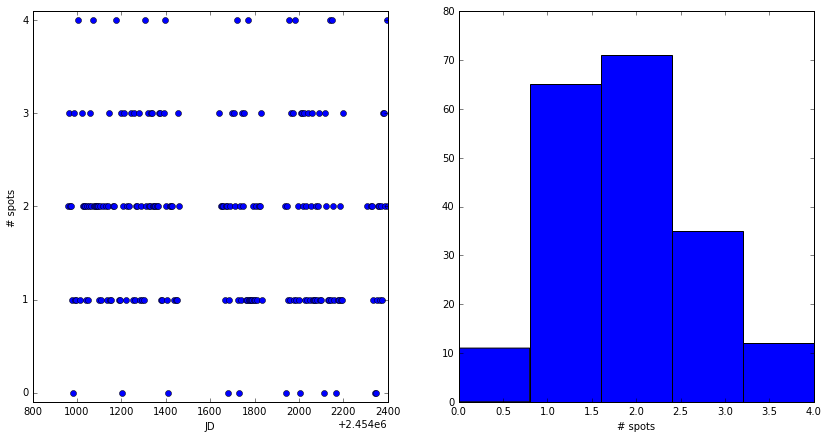

In [48]:
# Plot the distribution of spot numbers:

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(times, n_spots, 'o')
ax[0].set(xlabel='JD', ylabel='# spots')
ax[0].set_ylim([-0.1, max(n_spots)+0.1])
ax[1].hist(n_spots, len(np.unique(n_spots)))
ax[1].set(xlabel='# spots')
plt.show()

To estimate the number of detectable spots on the surface of the star, divide the number of spots per transit by the fractional surface area of the star occulted per transit.

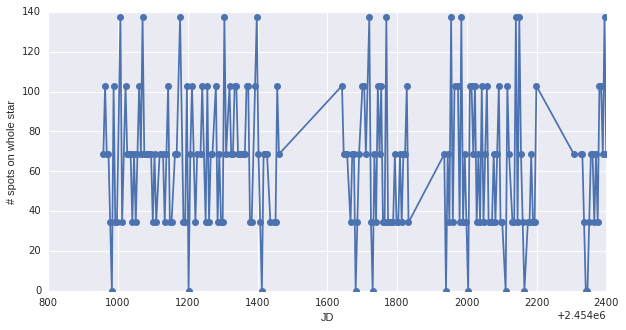

In [73]:
import seaborn as sns
sns.set_style("darkgrid")

from astropy.time import Time

n_spots_whole_star = n_spots/fractional_surface_area_per_transit

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(times, n_spots_whole_star, 'o-')
ax.set(xlabel='JD', ylabel='# spots on whole star')
plt.show()

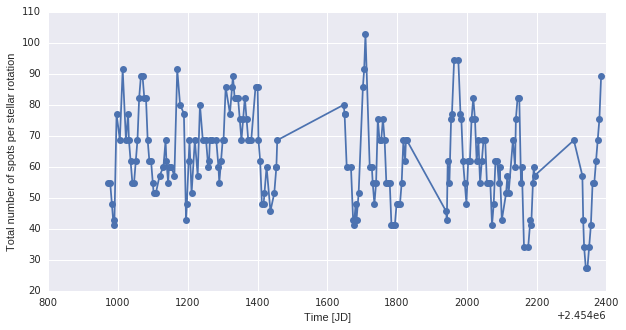

In [74]:
rotation_period = transit_params.per_rot

n_spots_per_rotation = []
times_per_rotation = []
for i in range(3, len(times) - 3):
    within_one_rotation = ((times[i] - rotation_period/2 <= times) & 
                           (times[i] + rotation_period/2 >= times))
    n_transits_in_window = np.count_nonzero(within_one_rotation)
    times_per_rotation.append(np.mean(times[within_one_rotation]))
    
    n_spots_in_window = np.sum(n_spots[within_one_rotation])
    n_spots_per_area = n_spots_in_window/(n_transits_in_window*fractional_surface_area_per_transit)
    n_spots_per_rotation.append(n_spots_per_area)

times_per_rotation = np.array(times_per_rotation)
n_spots_per_rotation = np.array(n_spots_per_rotation)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(times_per_rotation, n_spots_per_rotation, 'o-')
ax.set(ylabel='Total number of spots per stellar rotation',
       xlabel='Time [JD]')

plt.show()

Quick, silly search for periodicities in the number of spots occulted: 

Finding optimal frequency:
 - Estimated peak width = 0.00436
 - Using 5 steps per peak; omega_step = 0.000872
 - User-specified period range:  89 to 6e+02
 - Computing periods at 70 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Best period: 133.3958093181293


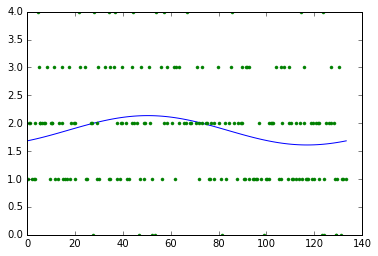

In [33]:
from gatspy.periodic import LombScargle

model = LombScargle(fit_period=True)
model.optimizer.period_range = (90, 600)
model.fit(times, n_spots, 0.5*np.ones_like(n_spots))
print("Best period: {0}".format(model.best_period))

tfit = np.linspace(0, model.best_period, 100)
yfit = model.predict(tfit)

plt.plot(tfit, yfit)
plt.plot(times % model.best_period, n_spots, '.')